In [1]:
import pandas as pd
import mlflow
import mlflow.sklearn

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

import numpy as np

import subprocess
import json

In [2]:
df = pd.read_csv("data/creditcard.csv")

In [3]:
input_json = df.iloc[:80].drop(["Time","Class"],axis=1).to_json(orient="split")

In [4]:
proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split",
                      "--data",input_json,"http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE,encoding='utf-8')

output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31202  100   240  100 30962   4776   601k --:--:-- --:--:-- --:--:--  609k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


In [5]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true,df2)

y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true,df2)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


/home/rhys/anaconda3/envs/mlops/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
normal = df[df.Class == 0].sample(frac=0.5,random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

normal_train, normal_test = train_test_split(normal, test_size=0.2,random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2,random_state=2020)

scaler = StandardScaler()
scaler.fit(pd.concat((normal,anomaly)).drop(["Time","Class"],axis=1))

StandardScaler()

In [9]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time","Class"],axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")

In [10]:
proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split",
                      "--data",input_json,"http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE,encoding='utf-8')

output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   8324  1067k --:--:-- --:--:-- --:--:-- 1107k


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true,preds)

y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true,preds)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.9875
Eval AUC 0.5


/home/rhys/anaconda3/envs/mlops/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time","Class"],axis=1))
preds = []

batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl","-X","POST","-H","Content-Type:application/json; format=pandas-split",
                      "--data",input_json,"http://127.0.0.1:1235/invocations"],
                      stdout=subprocess.PIPE,encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds,resp.values[0]))
    
eval_acc = accuracy_score(true,preds)
eval_auc = roc_auc_score(true,preds)

print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   7608   975k --:--:-- --:--:-- --:--:-- 1000k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   9703  1244k --:--:-- --:--:-- --:--:-- 1292k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   9030  1158k --:--:-- --:--:-- --:--:-- 1192k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   8122  1041k --:--:-- --:--:-- --:--:-- 1069k
  % Total    % Received % Xferd  Average Speed   Tim

100 31760  100   240  100 31520   9510  1219k --:--:-- --:--:-- --:--:-- 1240k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  11833  1517k --:--:-- --:--:-- --:--:-- 1550k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   9096  1166k --:--:-- --:--:-- --:--:-- 1192k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  10883  1395k --:--:-- --:--:-- --:--:-- 1476k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   7749   993k --:--:

100 31760  100   240  100 31520   8136  1043k --:--:-- --:--:-- --:--:-- 1069k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  10518  1348k --:--:-- --:--:-- --:--:-- 1348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   8778  1125k --:--:-- --:--:-- --:--:-- 1148k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520  10247  1314k --:--:-- --:--:-- --:--:-- 1348k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   9977  1279k --:--:

Eval Acc 0.99675
Eval AUC 0.5


100 31760  100   240  100 31520   8319  1067k --:--:-- --:--:-- --:--:-- 1107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31760  100   240  100 31520   8489  1088k --:--:-- --:--:-- --:--:-- 1148k


Text(0.5, 1.0, 'Confusion Matrix')

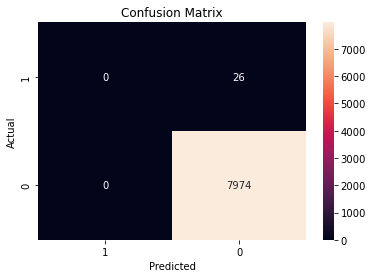

In [13]:
conf_matrix = confusion_matrix(true,preds)
ax = sns.heatmap(conf_matrix,annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")